In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import style
import shutil
import os
import operator
import warnings
from math import comb
from datetime import datetime
import pytz
from requests_html import AsyncHTMLSession
from collections import defaultdict
import nest_asyncio
from datetime import date
import unicodedata
import random
from matplotlib.ticker import MaxNLocator

warnings.filterwarnings("ignore")
matplotlib.rcParams['figure.facecolor'] = 'w'
matplotlib.rcParams['savefig.facecolor'] = 'w'

In [2]:
multiply_by_number = 1000 # To show the values better (no mathematicians)

In [3]:
def strip_accents(text):
    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return str(text)

In [4]:
cmap = plt.get_cmap("tab10")

In [5]:
teams = ['Qatar', 'Ecuador', 'Senegal', 'Netherlands', 'England', 'Iran', 'USA', 'Wales', 'Argentina', 'Saudi Arabia', 'Mexico', 'Poland', 'France', 'Australia', 'Denmark', 'Tunisia', 'Spain', 'Costa Rica', 'Germany', 'Japan', 'Belgium', 'Canada', 'Morocco', 'Croatia', 'Brazil', 'Serbia', 'Switzerland', 'Cameroon', 'Portugal', 'Ghana', 'Uruguay', 'South Korea']
teams.sort()
teams = list(map(str.upper,teams))
teams = np.array(teams)
teams

array(['ARGENTINA', 'AUSTRALIA', 'BELGIUM', 'BRAZIL', 'CAMEROON',
       'CANADA', 'COSTA RICA', 'CROATIA', 'DENMARK', 'ECUADOR', 'ENGLAND',
       'FRANCE', 'GERMANY', 'GHANA', 'IRAN', 'JAPAN', 'MEXICO', 'MOROCCO',
       'NETHERLANDS', 'POLAND', 'PORTUGAL', 'QATAR', 'SAUDI ARABIA',
       'SENEGAL', 'SERBIA', 'SOUTH KOREA', 'SPAIN', 'SWITZERLAND',
       'TUNISIA', 'USA', 'URUGUAY', 'WALES'], dtype='<U12')

In [6]:
users = pd.read_csv('website_users.csv')
users = users.iloc[: , 1:]
# users.loc[users['name'] == 'Riccardo Faccini', 'share3'] = 'SPAIN'
# users = users[users.name != 'Simone Lucchesi']
# users = users[users.name != 'Riccardo Faccini']
players = users['name'].tolist()
bdays = users['bday'].tolist()
money = users['money'].tolist()

betting_users = users.loc[users['money'] == 'YES']
betting_players = betting_users['name'].tolist()
betting_bdays = betting_users['bday'].tolist()

In [7]:
shares = []

for index, row in users.iterrows():
    shares_player = np.zeros(len(teams))
    for share in range(1,11):
        shares_player[np.argwhere(teams == row['share' + str(share)]).item()] += 1
    shares.append(shares_player.tolist())

shares = np.array(shares).T
shares.shape

(32, 109)

In [8]:
df = pd.DataFrame(shares, index=teams, columns=players)
df.head(5)

,Lamberto Pioli,Luca Pioli,Sophie Webster,Will Grassle,Maria Alejandra Chia Garcia,Pritish Patil,Sebastian Rojas,Raymond Wang,Sachin Kammula,Sebastián Carreño Leandro,...,Davide Benedetto,Adriano Vlad,Christine Ross,Kenneth Solomon,Kyrellos Ibrahim,Hannah Jonas,Sam Willett,Daniele Naim,Jillian Taylor,Bill Paine
ARGENTINA,2.0,2.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,2.0,...,4.0,3.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
AUSTRALIA,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
BELGIUM,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,4.0,1.0,...,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0
BRAZIL,1.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,...,3.0,3.0,1.0,2.0,0.0,1.0,2.0,1.0,3.0,1.0
CAMEROON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
total_shares = np.sum(shares,axis = 1)

betting_shares = []

for index, row in users.iterrows():
    if row['money'] == 'NO':
        continue
    shares_player = np.zeros(len(teams))
    for share in range(1,11):
        shares_player[np.argwhere(teams == row['share' + str(share)]).item()] += 1
    betting_shares.append(shares_player.tolist())

betting_shares = np.array(betting_shares).T

total_betting_shares = np.sum(betting_shares,axis = 1)

### Points

#### Automated web scraper

In [10]:
teams = ['Qatar', 'Ecuador', 'Senegal', 'Netherlands', 'England', 'Iran', 'USA', 'Wales', 'Argentina', 'Saudi Arabia', 'Mexico', 'Poland', 'France', 'Australia', 'Denmark', 'Tunisia', 'Spain', 'Costa Rica', 'Germany', 'Japan', 'Belgium', 'Canada', 'Morocco', 'Croatia', 'Brazil', 'Serbia', 'Switzerland', 'Cameroon', 'Portugal', 'Ghana', 'Uruguay', 'South Korea']
teams.sort()
teams = list(map(str.upper,teams))

In [11]:
nest_asyncio.apply()
url = 'https://www.flashscore.com/football/world/world-cup/results/'
asession = AsyncHTMLSession()

async def get_scores():
    r = await asession.get(url)
    await r.html.arender(timeout = 30)
    return r

results = asession.run(get_scores)
results = results[0]

times = results.html.find("div.event__time")
home_teams = results.html.find("div.event__participant.event__participant--home")
home_scores = results.html.find("div.event__score.event__score--home")
away_scores = results.html.find("div.event__score.event__score--away")
away_teams = results.html.find("div.event__participant.event__participant--away")
#event_part = results.html.find("div.event__part")

dict_res = defaultdict(list)

for ind in range(len(times)):

    if times[ind].text.split()[0][:2] == '14' and times[ind].text.split()[0][3:5] == '06':
        break

    dict_res['times'].append(times[ind].text.split('\n')[0])
    dict_res['home_teams'].append(home_teams[ind].text.split('\n')[0])
    home_score = home_scores[ind].text.split('\n')[0]
    away_score = away_scores[ind].text.split('\n')[0]
    dict_res['scores'].append(home_score + ' ' + away_score)
    dict_res['away_teams'].append(away_teams[ind].text.split('\n')[0])
    #dict_res['event_part'].append(event_part[ind].text)

df_res = pd.DataFrame(dict_res)
df_res = df_res.iloc[::-1].reset_index(drop=True)
df_res.tail(5)

,times,home_teams,scores,away_teams
57,09.12. 20:00,Netherlands,2 3,Argentina
58,10.12. 16:00,Morocco,1 0,Portugal
59,10.12. 20:00,England,1 2,France
60,13.12. 20:00,Argentina,3 0,Croatia
61,14.12. 20:00,France,2 0,Morocco


In [12]:
firstPlace = np.zeros(len(betting_players))
secondPlace = np.zeros(len(betting_players))
thirdPlace = np.zeros(len(betting_players))

firstPlace_general = np.zeros(len(players))
secondPlace_general = np.zeros(len(players))
thirdPlace_general = np.zeros(len(players))

teams_winners = {}

iterations = 1500

for iteration in range(iterations):

    # Group stage eliminations
    eliminated_teams = []
    eliminated_teams.extend(['QATAR', 'ECUADOR', 'WALES', 'IRAN', 'TUNISIA', 'DENMARK', 'MEXICO', 'SAUDI ARABIA', 'BELGIUM', 'CANADA', 'COSTA RICA', 'GERMANY', 'URUGUAY', 'GHANA', 'CAMEROON', 'SERBIA'])
    playoffs_teams = ['NETHERLANDS', 'SENEGAL', 'ENGLAND', 'USA', 'FRANCE', 'AUSTRALIA', 'ARGENTINA', 'POLAND', 'CROATIA', 'MOROCCO', 'SPAIN', 'JAPAN', 'PORTUGAL', 'SOUTH KOREA', 'BRAZIL', 'SWITZERLAND']

    points = np.zeros(len(teams))
    players_points = np.zeros((len(players),(len(df_res)+1)))
    betting_players_points = np.zeros((len(betting_players),(len(df_res)+1)))

    for index, row in df_res.iterrows():
            
        home_goal = int(row['scores'][0])
        away_goal = int(row['scores'][-1])
        home_team = row['home_teams'].upper()
        away_team = row['away_teams'].upper()
        
        day = int(row['times'][:2])
        month = int(row['times'][3:5])
        
        if datetime(2022, month, day) >= datetime(2022, 11, 20) and datetime(2022, month, day) < datetime(2022, 12, 3):
            
            # f_res.write('Group stage: %s %d - %d %s\n' %(home_team,home_goal,away_goal,away_team))
        
            if home_goal > away_goal:
                points[teams.index(home_team)] += 1
            elif home_goal == away_goal:
                points[teams.index(home_team)] += 0.5
                points[teams.index(away_team)] += 0.5
            else:
                points[teams.index(away_team)] += 1
                
        elif datetime(2022, month, day) >= datetime(2022, 12, 3) and datetime(2022, month, day) < datetime(2022, 12, 7):
            
            # f_res.write('Round of 16: %s %d - %d %s\n' %(home_team,home_goal,away_goal,away_team))
            
            # assign 1 point for all the teams that made it to the playoffs
            # points[teams.index(home_team)] += 1
            # points[teams.index(away_team)] += 1
            
            if home_goal > away_goal:
                points[teams.index(home_team)] += 2
                eliminated_teams.append(away_team)
            else:
                points[teams.index(away_team)] += 2
                eliminated_teams.append(home_team)
                
        elif datetime(2022, month, day) >= datetime(2022, 12, 9) and datetime(2022, month, day) < datetime(2022, 12, 11):
            
            # f_res.write('Quarter - final: %s %d - %d %s\n' %(home_team,home_goal,away_goal,away_team))
            
            if home_goal > away_goal:
                points[teams.index(home_team)] += 4
                eliminated_teams.append(away_team)
            else:
                points[teams.index(away_team)] += 4
                eliminated_teams.append(home_team)
                
        elif datetime(2022, month, day) >= datetime(2022, 12, 13) and datetime(2022, month, day) < datetime(2022, 12, 15):
            
            # f_res.write('Semi - final: %s %d - %d %s\n' %(home_team,home_goal,away_goal,away_team))
            
            if home_goal > away_goal:
                points[teams.index(home_team)] += 8
                eliminated_teams.append(away_team)
            else:
                points[teams.index(away_team)] += 8
                eliminated_teams.append(home_team)

        elif datetime(2022, month, day) >= datetime(2022, 12, 17) and datetime(2022, month, day) < datetime(2022, 12, 18):

            # f_res.write('Third-place final: %s %d - %d %s\n' %(home_team,home_goal,away_goal,away_team))
            
            if home_goal > away_goal:
                points[teams.index(home_team)] += 4
                eliminated_teams.append(away_team)
            else:
                points[teams.index(away_team)] += 4
                eliminated_teams.append(home_team)

        else:
            # f_res.write('Final: %s %d - %d %s\n' %(home_team,home_goal,away_goal,away_team))
            
            if home_goal > away_goal:
                points[teams.index(home_team)] += 16
                eliminated_teams.append(away_team)
            else:
                points[teams.index(away_team)] += 16
                eliminated_teams.append(home_team)

        if index >= 32 and len(playoffs_teams) > 0:
            points[teams.index(playoffs_teams[0])] += 1
            playoffs_teams.pop(0)
            
        players_points[:,index+1] = list(dict(zip(players,np.nansum(points / total_shares * shares.T,axis=1).round(decimals=3))).values())
        betting_players_points[:,index+1] = list(dict(zip(betting_players,np.nansum(points / total_betting_shares * betting_shares.T,axis=1).round(decimals=3))).values())

    points[teams.index('SENEGAL')] -= .5
    points[teams.index('USA')] -= .5
    points[teams.index('POLAND')] -= .5
    points[teams.index('AUSTRALIA')] -= .5
    points[teams.index('SPAIN')] -= .5
    points[teams.index('CROATIA')] -= .5
    points[teams.index('SWITZERLAND')] -= .5
    points[teams.index('SOUTH KOREA')] -= .5

    idx = 0
    prob_idx = -1
    probabilities = np.linspace(0.01,0.99,32)
    team_probabilities = {}

    with open('fifa_rank.txt') as file:
        for line in file:
            if idx < 2:
                idx += 1
                continue
            # probabilities[prob_idx] = 0.5
            if line.split()[0] == 'SOUTH':
                team_probabilities['SOUTH KOREA'] = probabilities[prob_idx]
            elif line.split()[0] == 'COSTA':
                team_probabilities['COSTA RICA'] = probabilities[prob_idx]
            elif line.split()[0] == 'SAUDI':
                team_probabilities['SAUDI ARABIA'] = probabilities[prob_idx]
            else:
                team_probabilities[line.split()[0]] = probabilities[prob_idx]
            prob_idx -= 1

    round_16 = []
    quarter = []
    semifinal = []
    third_place = [('CROATIA', 'MOROCCO')]
    final = [('ARGENTINA', 'FRANCE')]

    winners = []
    for game in round_16:
        if np.random.rand() < team_probabilities[game[0]] / (team_probabilities[game[0]] +  team_probabilities[game[1]]):
            winners.append(game[0])
            points[teams.index(game[0])] += 2
        else:
            winners.append(game[1])
            points[teams.index(game[1])] += 2
        if len(winners) == 2:
            quarter.append(tuple(winners))
            winners = []

    winners = []
    for game in quarter:
        if np.random.rand() < team_probabilities[game[0]] / (team_probabilities[game[0]] +  team_probabilities[game[1]]):
            winners.append(game[0])
            points[teams.index(game[0])] += 4
        else:
            winners.append(game[1])
            points[teams.index(game[1])] += 4
        if len(winners) == 2:
            semifinal.append(tuple(winners))
            winners = []

    winners = []
    losers = []
    for game in semifinal:
        if np.random.rand() < team_probabilities[game[0]] / (team_probabilities[game[0]] +  team_probabilities[game[1]]):
            winners.append(game[0])
            losers.append(game[1])
            points[teams.index(game[0])] += 8
        else:
            winners.append(game[1])
            losers.append(game[0])
            points[teams.index(game[1])] += 8
        if len(winners) == 2:
            final.append(tuple(winners))
            third_place.append(tuple(losers))
            
    trio = []

    for game in third_place:
        if np.random.rand() < team_probabilities[game[0]] / (team_probabilities[game[0]] +  team_probabilities[game[1]]):
            points[teams.index(game[0])] += 4
            trio.append(game[0])
        else:
            points[teams.index(game[1])] += 4
            trio.append(game[1])

    for game in final:
        if np.random.rand() < team_probabilities[game[0]] / (team_probabilities[game[0]] +  team_probabilities[game[1]]):
            points[teams.index(game[0])] += 16
            trio.append(game[1])
            trio.append(game[0])
        else:
            points[teams.index(game[1])] += 16
            trio.append(game[0])
            trio.append(game[1])
            
    trio = trio[::-1]

    values_team = (points / total_shares).round(decimals = 3)
    betting_values_team = (points / total_betting_shares).round(decimals = 3)

    general_ranking = dict(zip(players,np.nansum(values_team * shares.T,axis=1).round(decimals=3)))
    general_ranking = dict(sorted(general_ranking.items(), key=operator.itemgetter(1),reverse=True))

    betting_ranking = dict(zip(betting_players,np.nansum(betting_values_team * betting_shares.T,axis=1).round(decimals=3)))
    betting_ranking = dict(sorted(betting_ranking.items(), key=operator.itemgetter(1),reverse=True))    

    general_ranking_Matrix = np.zeros((len(players),2),dtype=object)
    general_ranking_Matrix[:,0] = list(general_ranking.keys())
    general_ranking_Matrix[:,1] = list(general_ranking.values())

    # np.savetxt(outdir + "general_ranking.txt", general_ranking_Matrix, delimiter=" ", fmt="%s") 

    betting_ranking_Matrix = np.zeros((len(betting_players),2),dtype=object)
    betting_ranking_Matrix[:,0] = list(betting_ranking.keys())
    betting_ranking_Matrix[:,1] = list(betting_ranking.values())

    # np.savetxt(outdir + "betting_ranking.txt", betting_ranking_Matrix, delimiter=" ", fmt="%s") 

    firstPlace[betting_players.index(betting_ranking_Matrix[0][0])] += 1 / (iterations)
    secondPlace[betting_players.index(betting_ranking_Matrix[1][0])] += 1 / (iterations)
    thirdPlace[betting_players.index(betting_ranking_Matrix[2][0])] += 1 / (iterations)

    firstPlace_general[players.index(general_ranking_Matrix[0][0])] += 1 / (iterations)
    secondPlace_general[players.index(general_ranking_Matrix[1][0])] += 1 / (iterations)
    thirdPlace_general[players.index(general_ranking_Matrix[2][0])] += 1 / (iterations)

    if tuple(trio) in teams_winners:
        teams_winners[tuple(trio)].append((betting_ranking_Matrix[0][0],betting_ranking_Matrix[1][0],betting_ranking_Matrix[2][0]))
    else:
        teams_winners[tuple(trio)] = [(betting_ranking_Matrix[0][0],betting_ranking_Matrix[1][0],betting_ranking_Matrix[2][0])]

    # if betting_ranking_Matrix[0][0] != 'Simone Lucchesi' and betting_ranking_Matrix[1][0] != 'Simone Lucchesi' and betting_ranking_Matrix[2][0] != 'Simone Lucchesi':
    #     print('---')
    #     print(quarter)
    #     print(semifinal)
    #     print(third_place)
    #     print(final)

Text(0.5, 1.0, 'General League')

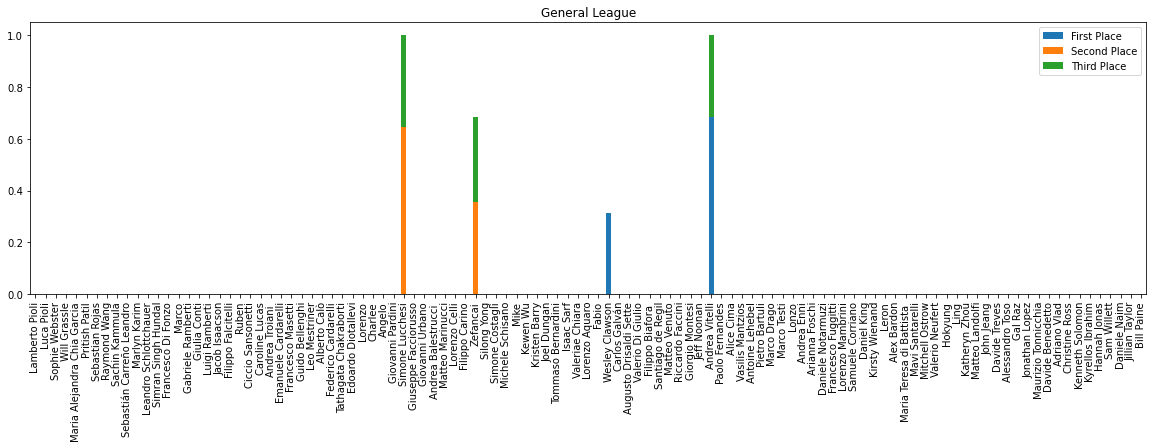

In [13]:
data = {'First Place': firstPlace_general,
        'Second Place': secondPlace_general,
        'Third Place': thirdPlace_general,
       }

fig, ax = plt.subplots(facecolor='white')
df_bar = pd.DataFrame(data,columns=['First Place','Second Place','Third Place'], index = players)
df_bar.plot.bar(figsize=(20,5),ax = ax, color = (cmap(0),cmap(1),cmap(2)), stacked=True)
ax.set_title('General League')

Text(0.5, 1.0, 'Betting League')

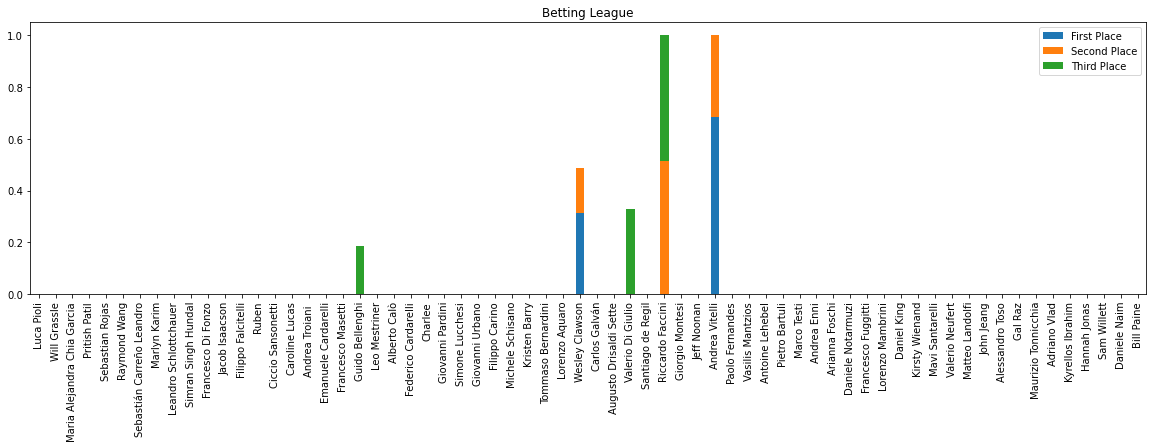

In [14]:
data = {'First Place': firstPlace,
        'Second Place': secondPlace,
        'Third Place': thirdPlace,
       }

fig, ax = plt.subplots(facecolor='white')
df_bar = pd.DataFrame(data,columns=['First Place','Second Place','Third Place'], index = betting_players)
df_bar.plot.bar(figsize=(20,5),ax = ax, color = (cmap(0),cmap(1),cmap(2)), stacked=True)
ax.set_title('Betting League')

### All permutations

In [15]:
eliminated_teams = []
eliminated_teams.extend(['QATAR', 'ECUADOR', 'WALES', 'IRAN', 'TUNISIA', 'DENMARK', 'MEXICO', 'SAUDI ARABIA', 'BELGIUM', 'CANADA', 'COSTA RICA', 'GERMANY', 'URUGUAY', 'GHANA', 'CAMEROON', 'SERBIA'])
playoffs_teams = ['NETHERLANDS', 'SENEGAL', 'ENGLAND', 'USA', 'FRANCE', 'AUSTRALIA', 'ARGENTINA', 'POLAND', 'CROATIA', 'MOROCCO', 'SPAIN', 'JAPAN', 'PORTUGAL', 'SOUTH KOREA', 'BRAZIL', 'SWITZERLAND']

points = np.zeros(len(teams))
players_points = np.zeros((len(players),(len(df_res)+1)))
betting_players_points = np.zeros((len(betting_players),(len(df_res)+1)))

for index, row in df_res.iterrows():
        
    home_goal = int(row['scores'][0])
    away_goal = int(row['scores'][-1])
    home_team = row['home_teams'].upper()
    away_team = row['away_teams'].upper()
    
    day = int(row['times'][:2])
    month = int(row['times'][3:5])
    
    if datetime(2022, month, day) >= datetime(2022, 11, 20) and datetime(2022, month, day) < datetime(2022, 12, 3):
        
        # f_res.write('Group stage: %s %d - %d %s\n' %(home_team,home_goal,away_goal,away_team))
    
        if home_goal > away_goal:
            points[teams.index(home_team)] += 1
        elif home_goal == away_goal:
            points[teams.index(home_team)] += 0.5
            points[teams.index(away_team)] += 0.5
        else:
            points[teams.index(away_team)] += 1
            
    elif datetime(2022, month, day) >= datetime(2022, 12, 3) and datetime(2022, month, day) < datetime(2022, 12, 7):
        
        # f_res.write('Round of 16: %s %d - %d %s\n' %(home_team,home_goal,away_goal,away_team))
        
        # assign 1 point for all the teams that made it to the playoffs
        # points[teams.index(home_team)] += 1
        # points[teams.index(away_team)] += 1
        
        if home_goal > away_goal:
            points[teams.index(home_team)] += 2
            eliminated_teams.append(away_team)
        else:
            points[teams.index(away_team)] += 2
            eliminated_teams.append(home_team)
            
    elif datetime(2022, month, day) >= datetime(2022, 12, 9) and datetime(2022, month, day) < datetime(2022, 12, 11):
        
        # f_res.write('Quarter - final: %s %d - %d %s\n' %(home_team,home_goal,away_goal,away_team))
        
        if home_goal > away_goal:
            points[teams.index(home_team)] += 4
            eliminated_teams.append(away_team)
        else:
            points[teams.index(away_team)] += 4
            eliminated_teams.append(home_team)
            
    elif datetime(2022, month, day) >= datetime(2022, 12, 13) and datetime(2022, month, day) < datetime(2022, 12, 15):
        
        # f_res.write('Semi - final: %s %d - %d %s\n' %(home_team,home_goal,away_goal,away_team))
        
        if home_goal > away_goal:
            points[teams.index(home_team)] += 8
            eliminated_teams.append(away_team)
        else:
            points[teams.index(away_team)] += 8
            eliminated_teams.append(home_team)

    elif datetime(2022, month, day) >= datetime(2022, 12, 17) and datetime(2022, month, day) < datetime(2022, 12, 18):

        # f_res.write('Third-place final: %s %d - %d %s\n' %(home_team,home_goal,away_goal,away_team))
        
        if home_goal > away_goal:
            points[teams.index(home_team)] += 4
            eliminated_teams.append(away_team)
        else:
            points[teams.index(away_team)] += 4
            eliminated_teams.append(home_team)

    else:
        # f_res.write('Final: %s %d - %d %s\n' %(home_team,home_goal,away_goal,away_team))
        
        if home_goal > away_goal:
            points[teams.index(home_team)] += 16
            eliminated_teams.append(away_team)
        else:
            points[teams.index(away_team)] += 16
            eliminated_teams.append(home_team)

    if index >= 32 and len(playoffs_teams) > 0:
        points[teams.index(playoffs_teams[0])] += 1
        playoffs_teams.pop(0)
        
    players_points[:,index+1] = list(dict(zip(players,np.nansum(points / total_shares * shares.T,axis=1).round(decimals=3))).values())
    betting_players_points[:,index+1] = list(dict(zip(betting_players,np.nansum(points / total_betting_shares * betting_shares.T,axis=1).round(decimals=3))).values())

points[teams.index('SENEGAL')] -= .5
points[teams.index('USA')] -= .5
points[teams.index('POLAND')] -= .5
points[teams.index('AUSTRALIA')] -= .5
points[teams.index('SPAIN')] -= .5
points[teams.index('CROATIA')] -= .5
points[teams.index('SWITZERLAND')] -= .5
points[teams.index('SOUTH KOREA')] -= .5

old_points = points.copy()

In [16]:
firstPlace = np.zeros(len(betting_players))
secondPlace = np.zeros(len(betting_players))
thirdPlace = np.zeros(len(betting_players))

firstPlace_general = np.zeros(len(players))
secondPlace_general = np.zeros(len(players))
thirdPlace_general = np.zeros(len(players))

round_16 = []

previous_points = old_points.copy()

for i_round16 in range(2**len(round_16)):
    num_bits = len(round_16)
    bits = [(i_round16 >> bit) & 1 for bit in range(num_bits - 1, -1, -1)]

    quarter = []
    points = previous_points.copy()
    winners = []
    for idx_round16, game_round16 in enumerate(round_16):
        if bits[idx_round16] == 0:
            winners.append(game_round16[0])
            points[teams.index(game_round16[0])] += 2
        else:
            winners.append(game_round16[1])
            points[teams.index(game_round16[1])] += 2
        if len(winners) == 2:
            quarter.append(tuple(winners))
            winners = []

    previous_quarter = points.copy()
    for i_quarter in range(2**len(quarter)):
        num_bits = len(quarter)
        bits = [(i_quarter >> bit) & 1 for bit in range(num_bits - 1, -1, -1)]

        semifinal = []
        points = previous_quarter.copy()
        winners = []
        for idx_quarter, game_quarter in enumerate(quarter):
            if bits[idx_quarter] == 0:
                winners.append(game_quarter[0])
                points[teams.index(game_quarter[0])] += 4
            else:
                winners.append(game_quarter[1])
                points[teams.index(game_quarter[1])] += 4
            if len(winners) == 2:
                semifinal.append(tuple(winners))
                winners = []

        previous_semifinal = points.copy()
        for i_semifinal in range(2**len(semifinal)):
            num_bits = len(semifinal)
            bits = [(i_semifinal >> bit) & 1 for bit in range(num_bits - 1, -1, -1)]

            third_place = [('CROATIA', 'MOROCCO')]
            final =  [('ARGENTINA', 'FRANCE')]
            points = previous_semifinal.copy()
            winners = []
            losers = []

            for idx_semifinal, game_semifinal in enumerate(semifinal):
                if bits[idx_semifinal] == 0:
                    winners.append(game_semifinal[0])
                    losers.append(game_semifinal[1])
                    points[teams.index(game_semifinal[0])] += 8
                else:
                    winners.append(game_semifinal[1])
                    losers.append(game_semifinal[0])
                    points[teams.index(game_semifinal[1])] += 8
                if len(winners) == 2:
                    final.append(tuple(winners))
                    third_place.append(tuple(losers))

            previous_third = points.copy()
            for i_third in range(2**len(third_place)):
                num_bits = len(third_place)
                bits = [(i_third >> bit) & 1 for bit in range(num_bits - 1, -1, -1)]

                points = previous_third.copy()
                for idx_third, game_third in enumerate(third_place):
                    if bits[idx_third] == 0:
                        points[teams.index(game_third[0])] += 4
                        w_thirdplace = game_third[0]
                    else:
                        points[teams.index(game_third[1])] += 4
                        w_thirdplace = game_third[1]

                previous_final = points.copy()
                for i_final in range(2**len(final)):
                    num_bits = len(final)
                    bits = [(i_final >> bit) & 1 for bit in range(num_bits - 1, -1, -1)]

                    points = previous_final.copy()
                    for idx_final, game_final in enumerate(final):
                        if bits[idx_final] == 0:
                            points[teams.index(game_final[0])] += 16
                            w_final = game_final[0]
                        else:
                            points[teams.index(game_final[1])] += 16
                            w_final = game_final[1]

                    values_team = (points / total_shares).round(decimals = 3)
                    betting_values_team = (points / total_betting_shares).round(decimals = 3)

                    general_ranking = dict(zip(players,np.nansum(values_team * shares.T,axis=1).round(decimals=3)))
                    general_ranking = dict(sorted(general_ranking.items(), key=operator.itemgetter(1),reverse=True))

                    betting_ranking = dict(zip(betting_players,np.nansum(betting_values_team * betting_shares.T,axis=1).round(decimals=3)))
                    betting_ranking = dict(sorted(betting_ranking.items(), key=operator.itemgetter(1),reverse=True))    

                    general_ranking_Matrix = np.zeros((len(players),2),dtype=object)
                    general_ranking_Matrix[:,0] = list(general_ranking.keys())
                    general_ranking_Matrix[:,1] = list(general_ranking.values())

                    # np.savetxt(outdir + "general_ranking.txt", general_ranking_Matrix, delimiter=" ", fmt="%s") 

                    betting_ranking_Matrix = np.zeros((len(betting_players),2),dtype=object)
                    betting_ranking_Matrix[:,0] = list(betting_ranking.keys())
                    betting_ranking_Matrix[:,1] = list(betting_ranking.values())

                    # np.savetxt(outdir + "betting_ranking.txt", betting_ranking_Matrix, delimiter=" ", fmt="%s") 

                    iterations = (2**len(round_16)) * (2**len(quarter)) * (2**len(semifinal)) * (2**len(third_place)) * (2**len(final))

                    firstPlace[betting_players.index(betting_ranking_Matrix[0][0])] += 1 / (iterations)
                    secondPlace[betting_players.index(betting_ranking_Matrix[1][0])] += 1 / (iterations)
                    thirdPlace[betting_players.index(betting_ranking_Matrix[2][0])] += 1 / (iterations)

                    # if betting_ranking_Matrix[0][0] != 'Simone Lucchesi' and betting_ranking_Matrix[1][0] != 'Simone Lucchesi' and betting_ranking_Matrix[2][0] != 'Simone Lucchesi':
                    #     print(quarter,semifinal,third_place,final)

                    firstPlace_general[players.index(general_ranking_Matrix[0][0])] += 1 / (iterations)
                    secondPlace_general[players.index(general_ranking_Matrix[1][0])] += 1 / (iterations)
                    thirdPlace_general[players.index(general_ranking_Matrix[2][0])] += 1 / (iterations)

                    print(third_place, w_thirdplace, final, w_final, betting_ranking_Matrix[0], betting_ranking_Matrix[1], betting_ranking_Matrix[2])

[('CROATIA', 'MOROCCO')] CROATIA [('ARGENTINA', 'FRANCE')] ARGENTINA ['Andrea Vitelli' 4.748] ['Riccardo Faccini' 3.985] ['Valerio Di Giulio' 3.538]
[('CROATIA', 'MOROCCO')] CROATIA [('ARGENTINA', 'FRANCE')] FRANCE ['Wesley Clawson' 4.206] ['Andrea Vitelli' 4.1] ['Riccardo Faccini' 3.769]
[('CROATIA', 'MOROCCO')] MOROCCO [('ARGENTINA', 'FRANCE')] ARGENTINA ['Andrea Vitelli' 5.892] ['Riccardo Faccini' 3.985] ['Guido Bellenghi' 3.797]
[('CROATIA', 'MOROCCO')] MOROCCO [('ARGENTINA', 'FRANCE')] FRANCE ['Andrea Vitelli' 5.244] ['Wesley Clawson' 3.826] ['Riccardo Faccini' 3.769]


Text(0.5, 1.0, 'General League')

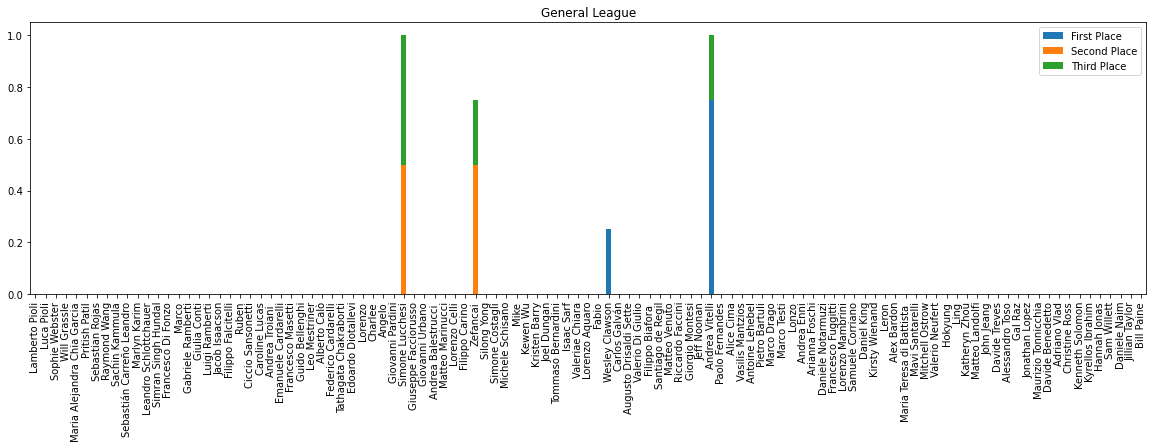

In [17]:
data = {'First Place': firstPlace_general,
        'Second Place': secondPlace_general,
        'Third Place': thirdPlace_general,
       }

fig, ax = plt.subplots(facecolor='white')
df_bar = pd.DataFrame(data,columns=['First Place','Second Place','Third Place'], index = players)
df_bar.plot.bar(figsize=(20,5),ax = ax, color = (cmap(0),cmap(1),cmap(2)), stacked=True)
ax.set_title('General League')

Text(0.5, 1.0, 'Betting League')

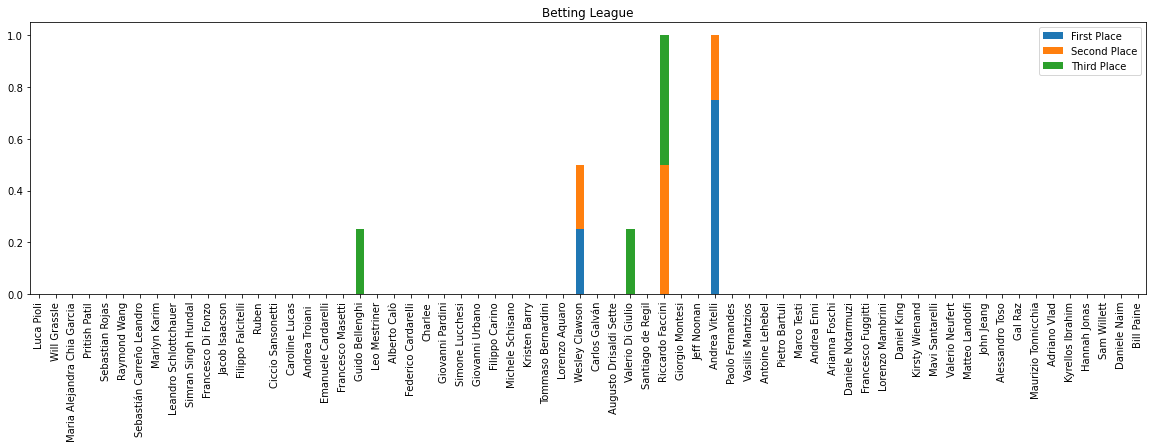

In [18]:
data = {'First Place': firstPlace,
        'Second Place': secondPlace,
        'Third Place': thirdPlace,
       }

fig, ax = plt.subplots(facecolor='white')
df_bar = pd.DataFrame(data,columns=['First Place','Second Place','Third Place'], index = betting_players)
df_bar.plot.bar(figsize=(20,5),ax = ax, color = (cmap(0),cmap(1),cmap(2)), stacked=True)
ax.set_title('Betting League')

In [19]:
probabilities_podium = list(zip(betting_players, ((firstPlace+secondPlace+thirdPlace) * 100).round(2)))
res = pd.DataFrame(probabilities_podium, columns = ['<b>Player</b>', '<b>Probabilities</b>'])
res.index += 1
res = res.sort_values(by=res.columns[-1], ascending=False)
res.head(20)

,<b>Player</b>,<b>Probabilities</b>
38,Riccardo Faccini,100.0
41,Andrea Vitelli,100.0
33,Wesley Clawson,50.0
36,Valerio Di Giulio,25.0
20,Guido Bellenghi,25.0
44,Antoine Lehebel,0.0
48,Arianna Foschi,0.0
47,Andrea Enni,0.0
46,Marco Testi,0.0
45,Pietro Bartuli,0.0


In [20]:
# res['<b>Player</b>'].to_numpy()[:19]

In [21]:
# probabilities_podium = list(zip(betting_players, ((firstPlace+secondPlace+thirdPlace) * 100).round(2)))
# print(np.sum(((firstPlace+secondPlace+thirdPlace) * 100).round(2)))
# res = pd.DataFrame(probabilities_podium, columns = ['<b>Player</b>', '0'])
# res.index += 1
# # res = res.sort_values(by=['<b>Player</b>'])
# res.to_csv('betting_winner.csv',index=False) 

# res = res.set_index('<b>Player</b>')

# for index, row in res.iterrows():
#     plt.plot(row, label=index)
# plt.show()